# Finding Zestimate erros
 by Jared Godar and Daniel Northcutt

# Goals:
  - Work through datascience pipline for zillow data, documenting the process
  - Use clustering and regression modeling to beat the baseline model
  - Find the drivers for logerror in the Zestimate model


### Through data exploration we came to focus on 5 questions:
- What are the drivers of logerror
- Does logerror vary within geographical cluster
- Does logerror vary within price cluster
- Does logerror vary within size cluster
- Does logerror vary within tax cluster


<hr style="border:1px solid black"> </hr>


In [1]:
##IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.formula.api import ols

from datetime import date
from scipy import stats


#Custom functions
from env import host, user, password #Database credentials
import wrangle3
import env
import eval_model
import explore2
import model
## Evaluation tools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

<hr style="border:1px solid black"> </hr>


# Data Wrangle & Exploration

### Wrangle
1. Pulled 2017 transaction data from sql server
2. Ensure filtered for single family homes (bedroom and bathroom counts > 0, home size > 350 sq. ft.).
3. Clean function removes outliers (over $5M homes).
4. Add county name column from fips data.
5. Feature Engineering Add columns for age of home, age bins, taxrate, size in acres, bins of acre size, sq_ft bins, structure_dollar_per_sqft, structure_dollar_sqft_bin, land_dollar_per_sqft, lot_dollar_sqft_bin, calculate bathroom/bedroom ratio
6. Update datatypes of binned values
7. Remove outliers with invalid zipcodes
8. Scale data using linear scaler
9. Add baseline as logerror mean.
10. Create clusters for area, prize, size, and tax information (see below).
11. Give clusters real-world names.
12. Encode categorical data (clusters).
13. Split data into train, validate, test.
14. Split into X (features) and y (target) dataframes

<hr style="border:1px solid black"> </hr>


In [2]:
#pulling our function from wrangle3.py
train, X_train, y_train, X_validate, y_validate, X_test, y_test=wrangle3.wrangle()


In [3]:
# train dataset encoded with clustering, dummies, bins, scaled features
# 36,384 rows and 70 columns
train.shape

(36384, 70)

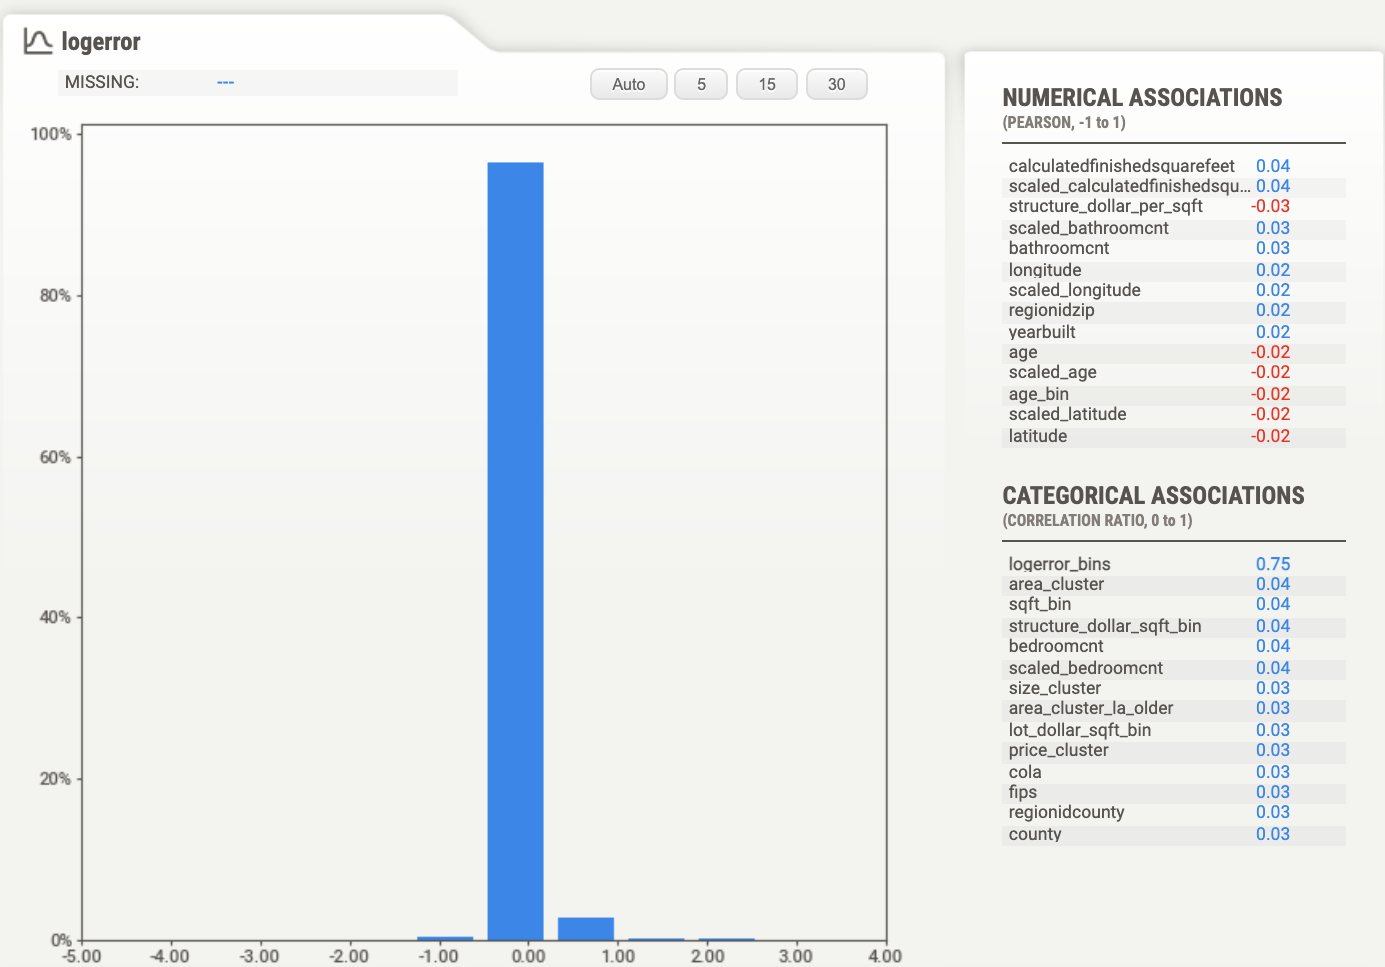

In [4]:
# sweet_viz import to run correlation on dataset to logerror 
# this shows that multiple features offer weak correlations 
# thus telling us that many features will be needed for a strong model

from IPython.display import Image
Image("logerror.png")

In [5]:
# Pearson R to test calculatedfinishedsquarefeet to logerror

explore2.calculatedfinishedsquarefeet_pearsonr()

 The correlation between the calculatedfinishedsquarefeet and the logerror: 0.0355
 The P value between the calculatedfinishedsquarefeet and the logerror:  1.336e-11
 
Reject null hypothesis:
 'There is no correlation between the calculatedfinishedsquarefeet and the logerror'


We now move forward with our alternative hypothesis: 
 'There is a correlation between the calculatedfinishedsquarefeet and logerror'


This is positive correlation with a low p-value.


In [6]:
# Pearson R to test structure_dollar_sqft_bin to logerror

explore2.structure_dollar_sqft_bin_pearsonr()

 The correlation between the structure_dollar_sqft_bin and the logerror: -0.0350
 The P value between the structure_dollar_sqft_bin and the logerror:  2.363e-11
 
Reject null hypothesis:
 'There is no correlation between the structure_dollar_sqft_bin and the logerror'


We now move forward with our alternative hypothesis: 
 'There is a correlation between the structure_dollar_sqft_bin and logerror'


This is a negative correlation with a low p-value.


In [7]:
# Pearson R to test scaled_bathroomcnt to logerror


explore2.scaled_bathroomcnt_pearsonr()

 The correlation between the scaled_bathroomcnt and the logerror: 0.0309
 The P value between the scaled_bathroomcnt and the logerror:  3.71e-09
 
Reject null hypothesis:
 'There is no correlation between the scaled_bathroomcnt and the logerror'


We now move forward with our alternative hypothesis: 
 'There is a correlation between the scaled_bathroomcnt and logerror'


This is positive correlation with a low p-value.


# Explore Takeaways:
- Using our data we ran correlation tests to find the greatest correlations with logerror.
- We backed these findings by running Pearsons R which all showed low p-values.
- Using these features and data exploration we next moved to finding meaning in our data through clustering
- Code for statistical tests can be seen at explore2.py

<hr style="border:1px solid black"> </hr>


# Clustering
    - Through data exploration we clustered features by similar attributes giving meaning to our data
    - We settled on 4 clusters based on geographical location, size features, price features, and tax features
    - These clusters gave a deep understanding of the questions asked
    - We plotted K 2-20 to find the optimal K for each of the clusters then properly labeled the clusters created 


# Cluster 1: Area

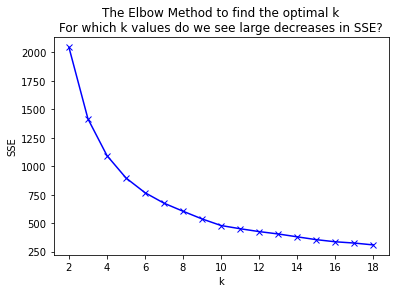

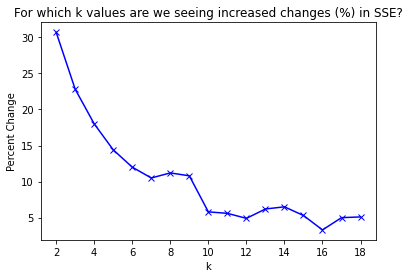

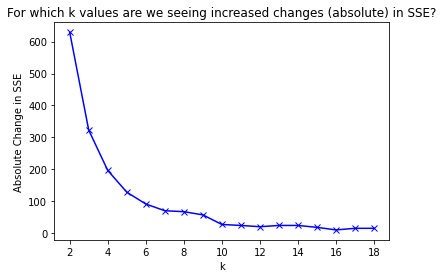

,k,sse,delta,pct_delta
0,2,2044.59358,629.00000,30.70000
1,3,1416.03399,323.00000,22.80000
2,4,1093.33540,197.00000,18.00000
3,5,896.73794,129.00000,14.40000
4,6,767.38997,92.00000,12.00000
5,7,675.16217,71.00000,10.50000
6,8,604.57558,68.00000,11.20000
7,9,536.90796,58.00000,10.80000
8,10,478.98563,28.00000,5.80000
9,11,451.04644,25.00000,5.60000


In [8]:
# Our first cluster - Area
# Using the Elbow method we decided to cluster on k =6

cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)
explore2.find_k(X_train, cluster_vars, k_range)

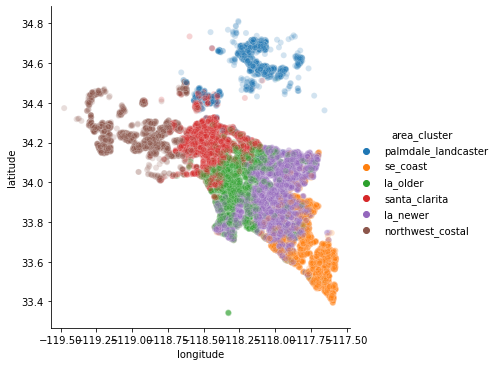

In [9]:
# Clustered data represented by geographical location and hued by the cluster
sns.relplot(data=X_train, x='longitude', y='latitude', hue='area_cluster', alpha =0.2);

Through plotting the clusters on Google Maps we gave labels to understand the groupings
Below is the images used to label our data:

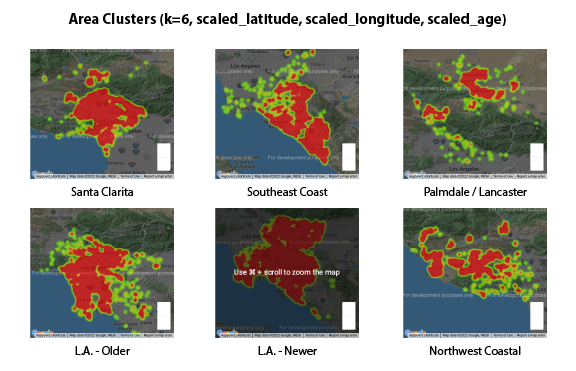

In [10]:
Image("area_clusters.png")

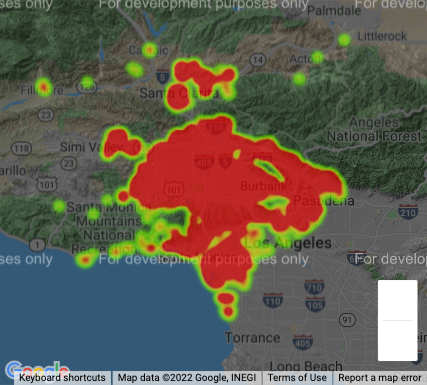

In [11]:
Image("area0.png")

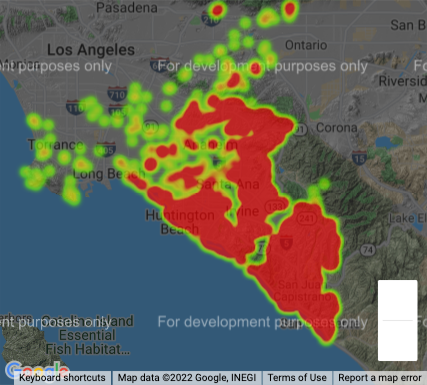

In [12]:
Image("area1.png")

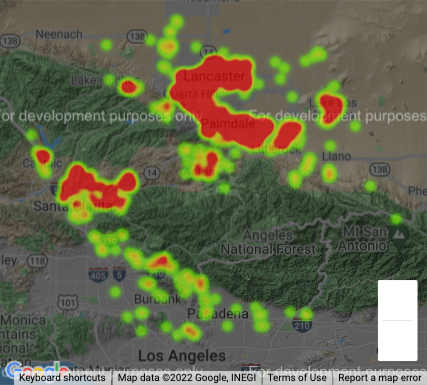

In [13]:
Image("area2.png")

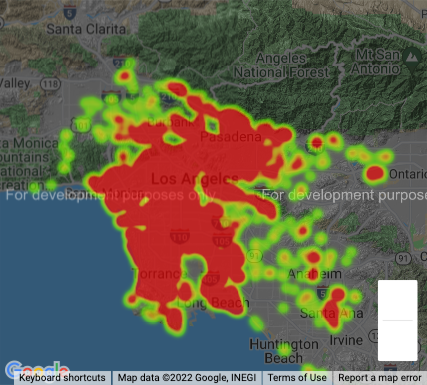

In [14]:
Image("area3.png")

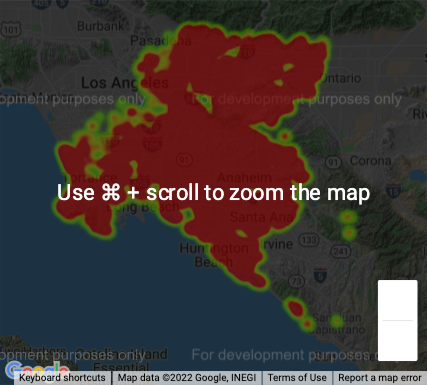

In [15]:
Image("area4.png")

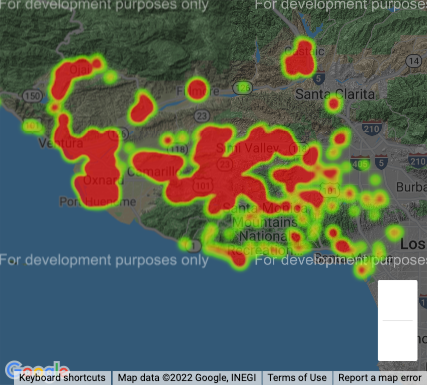

In [16]:
Image("area5.png")

# Cluster 2 : Size

features = 'scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio'

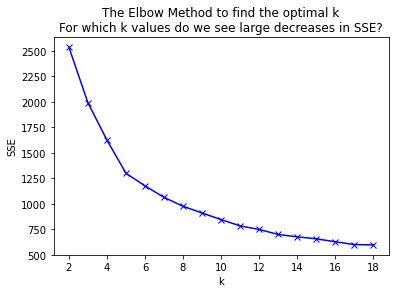

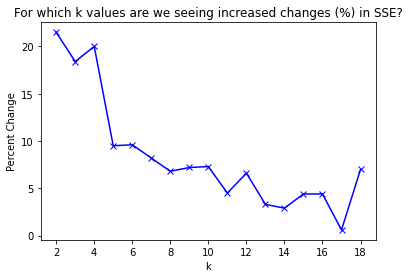

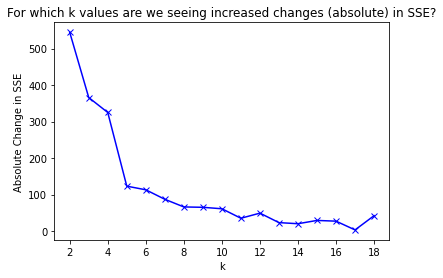

,k,sse,delta,pct_delta
0,2,2533.74932,545.00000,21.50000
1,3,1988.74336,366.00000,18.40000
2,4,1623.21606,325.00000,20.00000
3,5,1298.03629,123.00000,9.50000
4,6,1174.74353,113.00000,9.60000
5,7,1061.94234,87.00000,8.20000
6,8,974.77293,66.00000,6.80000
7,9,908.89041,65.00000,7.20000
8,10,843.75513,61.00000,7.30000
9,11,782.41509,35.00000,4.50000


In [17]:
# Using the Elbow method we decided to cluster on k =7

cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,20)

explore2. find_k(X_train, cluster_vars, k_range)

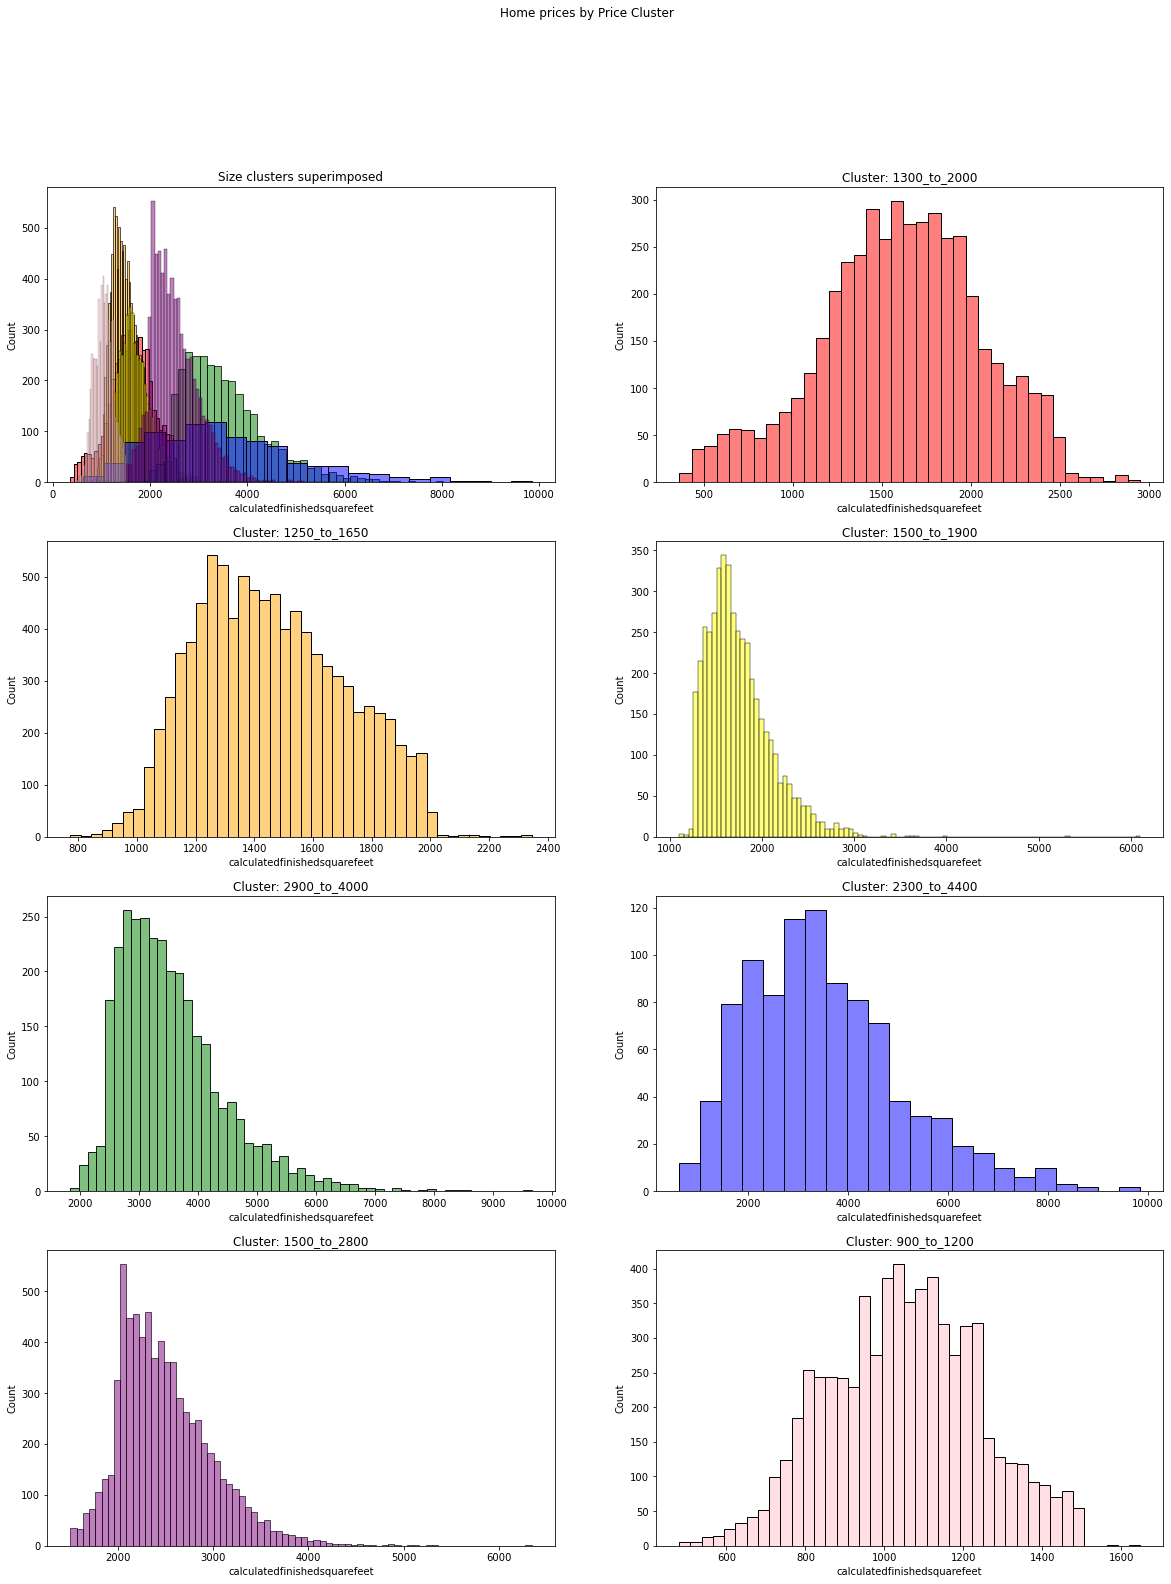

In [18]:
#Visual representation of size clustering by overlaying and looking at each cluster individually for meaning
explore2.plot_size_clusters()

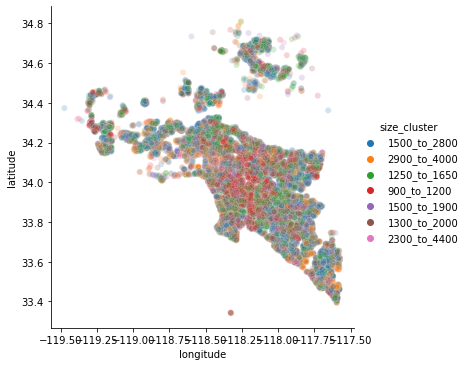

In [19]:
# Our clusters represented across the zillow dataset showing the distribution by lat/long

sns.relplot(data=X_train, x='longitude', y='latitude', hue='size_cluster', alpha =0.2);

# Cluster 3: Price
features = 'taxrate', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin'

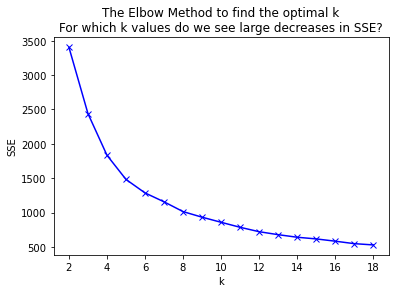

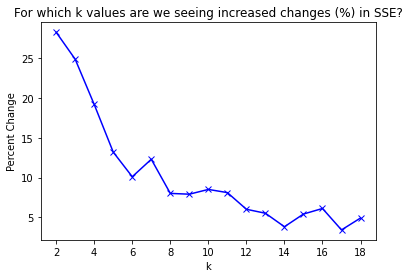

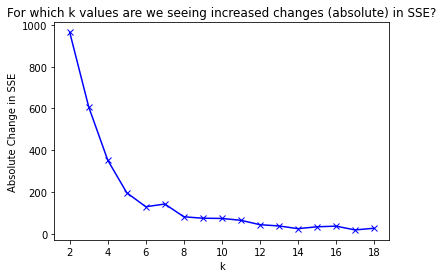

,k,sse,delta,pct_delta
0,2,3405.13764,965.00000,28.30000
1,3,2440.55213,607.00000,24.90000
2,4,1833.93291,352.00000,19.20000
3,5,1482.03421,196.00000,13.20000
4,6,1285.75689,129.00000,10.10000
5,7,1156.27481,142.00000,12.30000
6,8,1013.87153,81.00000,8.00000
7,9,932.49450,74.00000,7.90000
8,10,858.47659,73.00000,8.50000
9,11,785.52253,64.00000,8.10000


In [20]:
# Using the Elbow method we decided to cluster on k = 5
cluster_vars = ['taxrate', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin']
cluster_name = 'price_cluster'

explore2.find_k(X_train, cluster_vars, k_range)

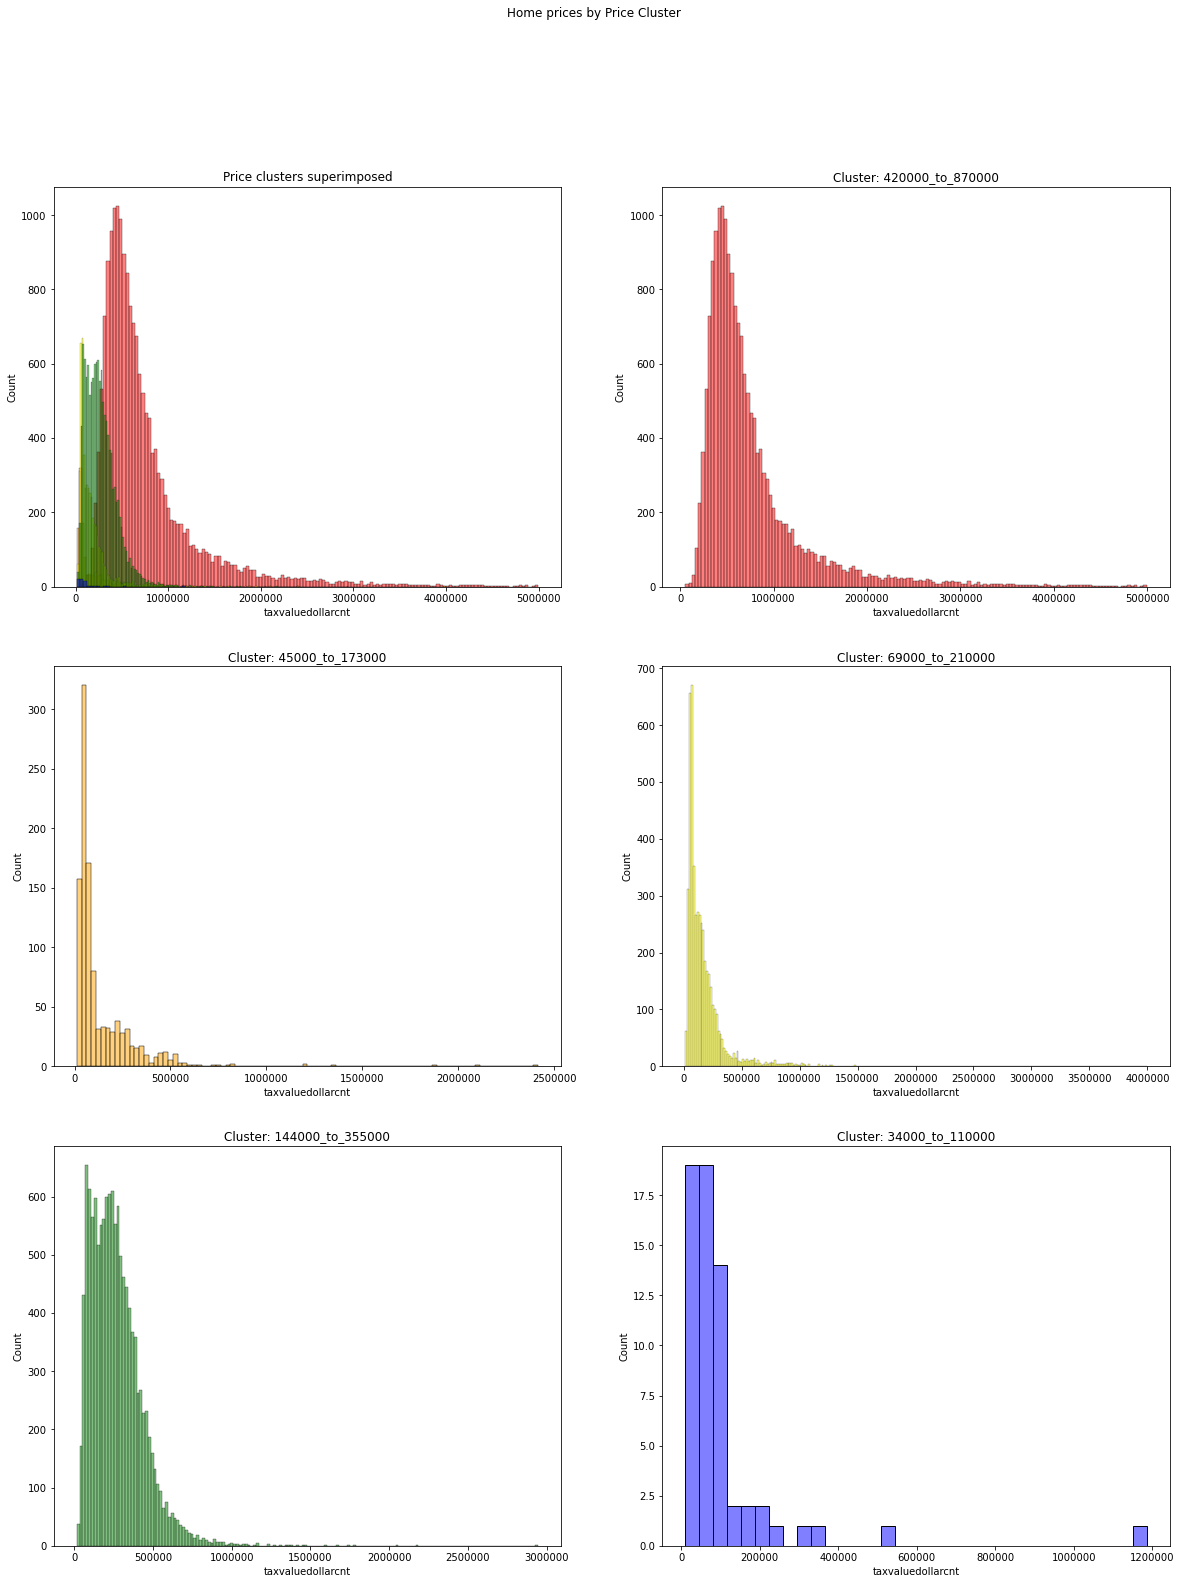

In [21]:
#Visual representation of price clustering by overlaying and looking at each cluster individually for meaning

explore2.plot_prices_clusters()

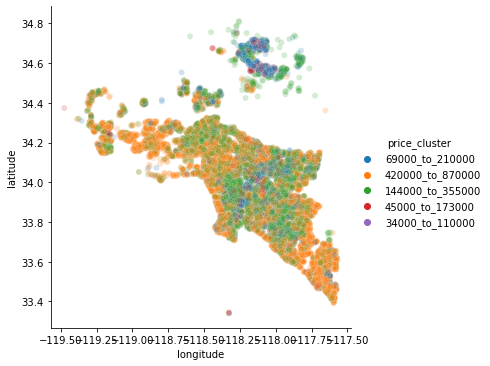

In [22]:
# Our clusters represented across the zillow dataset showing the distribution by lat/long

sns.relplot(data=X_train, x='longitude', y='latitude', hue='price_cluster', alpha =0.2);

# Cluster 4: Tax
features = 'taxamount', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt'

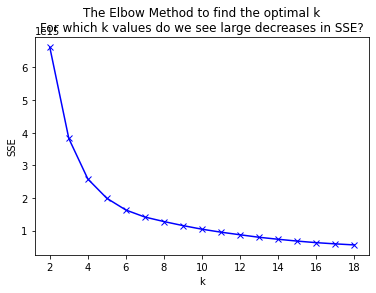

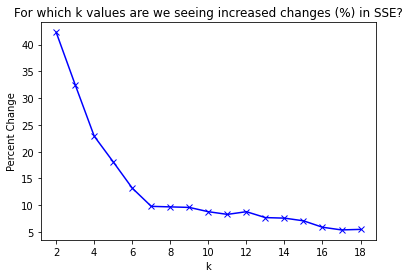

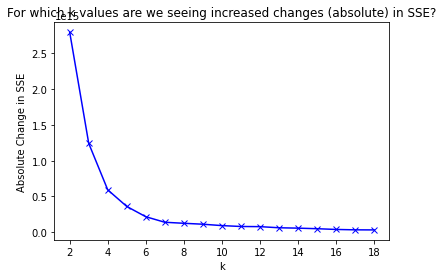

,k,sse,delta,pct_delta
0,2,6619195678852811.00000,2796837012102888.00000,42.30000
1,3,3822358666749923.00000,1241776121905078.00000,32.50000
2,4,2580582544844844.50000,591291206203615.00000,22.90000
3,5,1989291338641229.75000,359207425591332.00000,18.10000
4,6,1630083913049897.75000,215512437088164.00000,13.20000
5,7,1414571475961733.50000,137985849514373.00000,9.80000
6,8,1276585626447360.25000,123724406296065.00000,9.70000
7,9,1152861220151295.00000,110716579323969.00000,9.60000
8,10,1042144640827326.00000,91297699981194.00000,8.80000
9,11,950846940846132.12500,79039531809282.00000,8.30000


In [23]:
# Using the Elbow method we decided to cluster on k = 5

cluster_vars = ['taxamount', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt']
cluster_name = 'tax_cluster'
k_range = range(2,20)

explore2.find_k(X_train, cluster_vars, k_range)

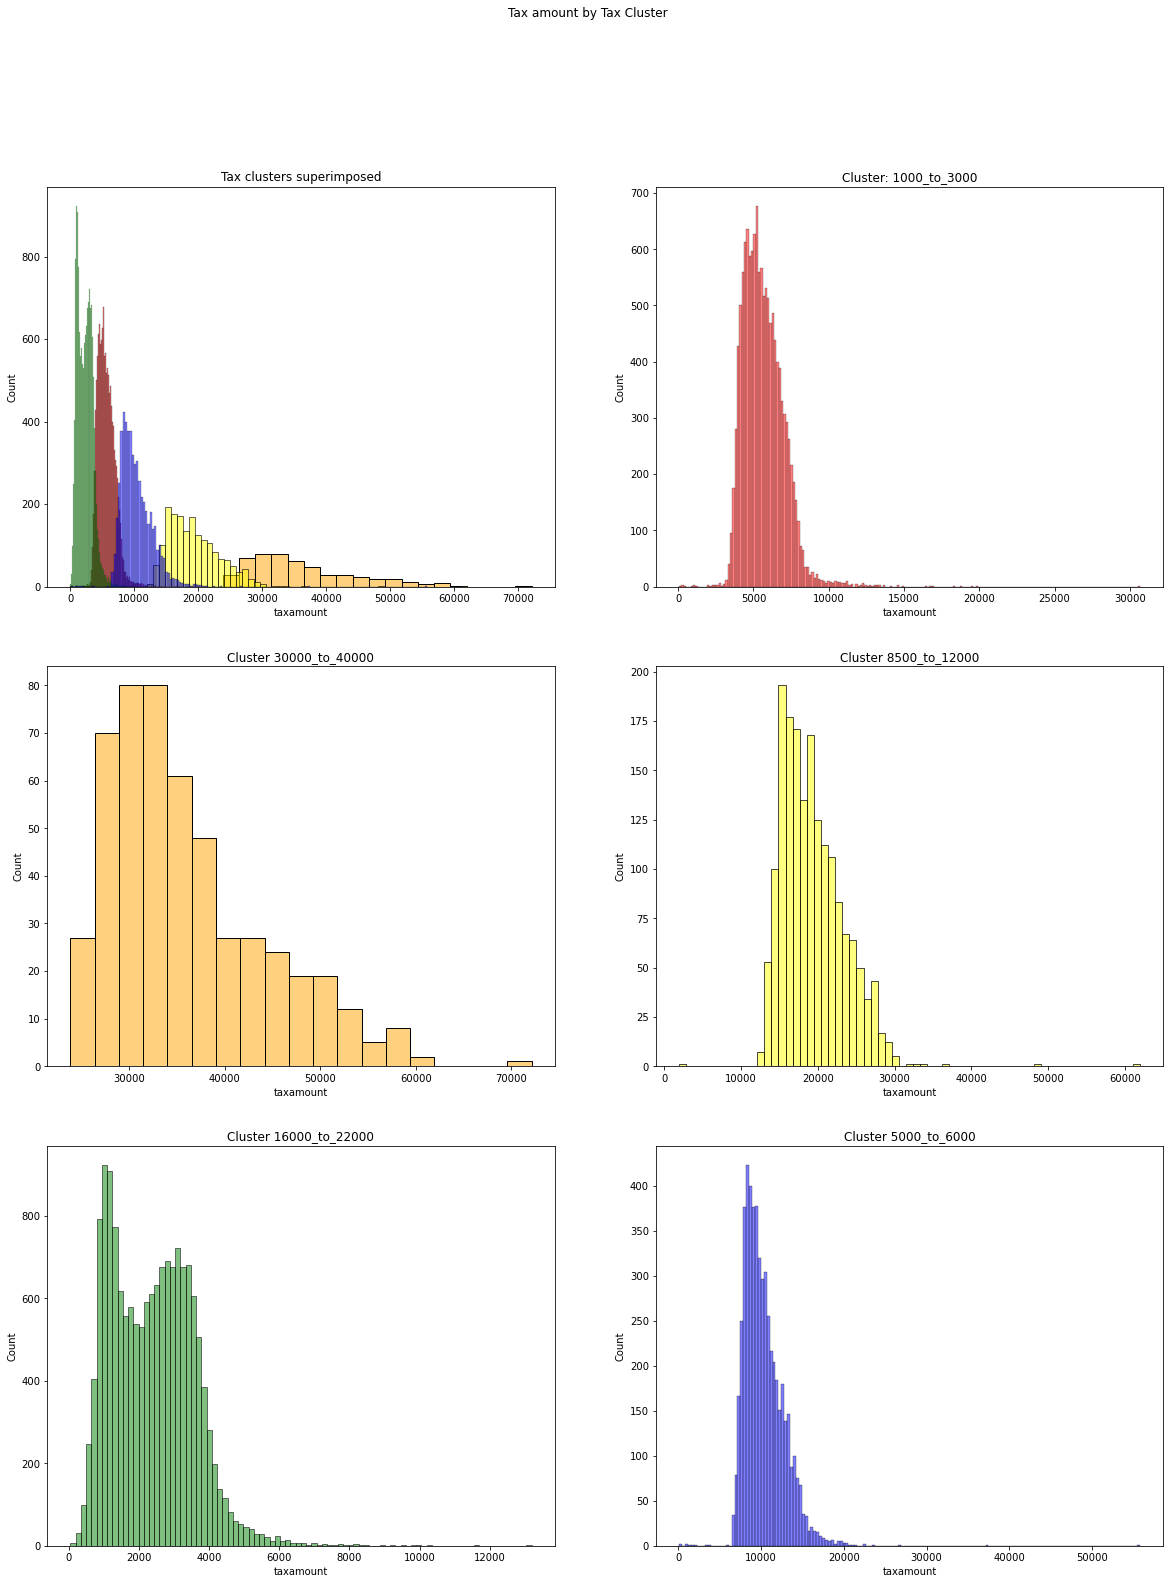

In [24]:
#Visual representation of price clustering by overlaying and looking at each cluster individually for meaning
explore2.plot_tax_cluster()

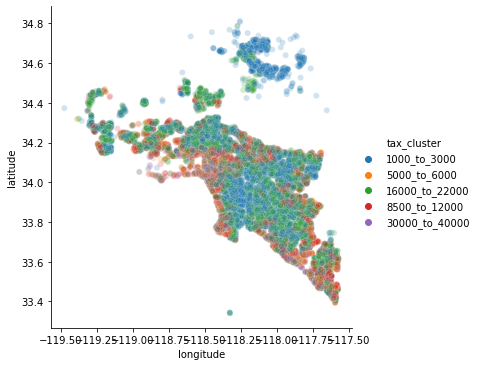

In [25]:
# Our clusters represented across the zillow dataset showing the distribution by lat/long
sns.relplot(data=X_train, x='longitude', y='latitude', hue='tax_cluster', alpha =0.2);

# Clustering Takeaways:
    - Each of the four clustering presented strong relationships of features to further understand the data
    - No single feature was used in multiple clusters
    - Clusters were given labels through detailed analysis to understand their deeper meaning
    - Clusters identity proved to be a useful feature for predicting error

<hr style="border:1px solid black"> </hr>


### Code for the graphs of logerror bars which is featured in report_notebook2.ipynb can be seen on jg_viz_suites.ipynb


<hr style="border:1px solid black"> </hr>


# Modeling

    - Using multiple feature combinations we tested 6 different OLS models on the train and validate datasets

### Model 1: 

We tested OLS on 10 features : geo(area), size and price clusters


In [26]:
model.model_1()

train_rmse: 0.17434420435971837
train_r2: 0.004356344124752831
validate_rmse: 0.1698736346947211
validate_model1_r2: 0.003246770193748083


### Model 2: 

We tested OLS on 11 features : geo(area) cluster area, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, acres, age


In [27]:
model.model_2()

train_rmse: 0.17445037402983032
train_r2: 0.0031433488903251927
validate_rmse: 0.1699489533880002
validate_model2_r2: 0.002362691930032468


### Model 3: 

We tested OLS on 12 features : geo(area) cluster area, taxamount, taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, acres, age

In [28]:
model.model_3()

train_rmse: 0.1745162616397184
train_r2: 0.0023902074214285918
validate_rmse: 0.17009804083854688
validate_model3_r2: 0.000611572682462036


### Model 4:

We tested OLS on 6 features : taxvaluedollarcnt, structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, acres, age

In [29]:
model.model_4()

train_rmse: 0.17465278398439674
train_r2: 0.0008287563671917075
validate_rmse: 0.1701129732541704
validate_model4_r2: 0.00043609813462519575


### Model 5: 

We tested OLS on 22 features : geo(area) clusters, size clusters, price clusters, taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount

In [30]:
model.model_5()

train_rmse: 0.17431423554050413
train_r2: 0.004698606149656004
validate_rmse: 0.16979680305303887
validate_model5_r2: 0.004148203409923723


### Model 6: 

We tested OLS on 22 features : geo(area)clusters, size clusters, price clusters, tax clusters

In [31]:
model.model_6()

train_rmse: 0.1743341213915913
train_r2: 0.004471504281496008
validate_rmse: 0.16984115129762245
validate_model6_r2: 0.0036279339377519593


In [32]:
# Test model that we are not evaluating
model.model_7()

train_rmse: 0.17430120096285087
train_r2: 0.004847450542280862
validate_rmse: 0.1695587479046829
validate_model7_r2: 0.0069386147542630505


In [33]:
# Test model that we are not evaluating
model.model_8()

train_rmse: 0.17433016362031462
train_r2: 0.004516705178828406
validate_rmse: 0.16965435137048301
validate_model8_r2: 0.005818449894350097


# Model Takeaways:
- All models performed beat the baseline RMSE for both train and validate
    
- Of our 6 models, model #5 was the best performing beating RMSE baseline by:
     0.23388% train
     0.20561% validate
        
- The tax value cluster was used in model #6 but model #5 was not clustered, which performed better
    
- Baseline model is very strong and we could only offer slight marginal improvements
- Incoporating cluster data, our model improved over baseline in train and validate

<hr style="border:1px solid black"> </hr>


# Test Dataset
- Test dataset can be seen on report_notebook2.ipynb it was not performed in this preliminary notebook due to keeping the data unseen until the end
- Testing data ran beat baseline by 0.0052 or 2.95% on the unseen test data

# Conclusion / Takeaways:
- Clustering in multiple sets offered great insights in understanding our data at a deeper level    

- Baseline was extremely hard to beat and took great deal of scaling and clustering the data to outperform
    
- We could spend countless hours to find new insights and ways to beat our current model through different modeling technqiues, finding meaningful values to impute in NA values, and a deeper exploration of clustered data